In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import gmaps
from scipy.stats import linregress
import scipy.stats as st
from pprint import pprint
from sklearn.linear_model import LinearRegression


covidcasesus_pd = "../Resources/covid_confirmed_usafacts.csv"
covidbycounty_pd = "../Resources/covid_county_population_usafacts.csv"

In [34]:
#Reading covid-19 cases and creating a dataframe 
covidcasesus_pd = pd.read_csv(covidcasesus_pd, encoding="ISO-8859-1")
covidcasesus_pd

,countyFIPS,County Name,State,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,2021,2023,2030,2048,2059,2074,2082,2103,2126,2141
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,6443,6475,6615,6637,6658,6694,6712,6743,6768,6888
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,996,997,1012,1031,1033,1033,1042,1045,1055,1056
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,801,811,825,828,840,843,850,856,861,866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,56037,Sweetwater County,WY,56,0,0,0,0,0,0,...,436,443,451,456,462,476,488,505,522,553
3191,56039,Teton County,WY,56,0,0,0,0,0,0,...,715,727,740,743,747,756,761,772,779,796
3192,56041,Uinta County,WY,56,0,0,0,0,0,0,...,407,410,425,428,431,442,451,462,469,479
3193,56043,Washakie County,WY,56,0,0,0,0,0,0,...,142,143,144,145,145,146,151,153,153,158


In [35]:
#Extracting data on two states of interest and creating a new dataframe with this data
covidcasesus_pd_CA_TX = covidcasesus_pd.set_index("State")

covidcasesus_pd_CA_TX = covidcasesus_pd_CA_TX.loc[["CA","TX"]]

covidcasesus_pd_CA_TX = covidcasesus_pd_CA_TX.reset_index()

covidcasesus_pd_CA_TX

,State,countyFIPS,County Name,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,CA,0,Statewide Unallocated,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CA,6000,Grand Princess Cruise Ship,6,0,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
2,CA,6001,Alameda County,6,0,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
3,CA,6003,Alpine County,6,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
4,CA,6005,Amador County,6,0,0,0,0,0,0,...,276,287,291,291,291,299,301,302,308,311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,TX,48499,Wood County,48,0,0,0,0,0,0,...,621,623,626,626,626,633,636,639,655,655
311,TX,48501,Yoakum County,48,0,0,0,0,0,0,...,289,289,289,289,289,289,289,300,304,319
312,TX,48503,Young County,48,0,0,0,0,0,0,...,497,507,521,535,535,535,559,578,591,605
313,TX,48505,Zapata County,48,0,0,0,0,0,0,...,342,342,343,345,346,346,352,352,352,357


In [36]:
#Checking number of unique counties names to avoide duplicates
covidcasesus_pd_CA_TX["County Name"].nunique()

312

In [37]:
#Checking on duplicates
duplicate = covidcasesus_pd_CA_TX[covidcasesus_pd_CA_TX.duplicated(subset=["County Name"], keep=False)]
duplicate
#There is no "true" duplicates, 2 pairs of counties in both states have the same names + Statewide Unallocated

,State,countyFIPS,County Name,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,CA,0,Statewide Unallocated,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,CA,6059,Orange County,6,0,0,0,0,1,1,...,57635,57848,58010,58326,58573,58725,58980,59213,59442,59718
54,CA,6105,Trinity County,6,0,0,0,0,0,0,...,25,25,25,25,25,27,27,28,28,33
60,TX,0,Statewide Unallocated,48,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241,TX,48361,Orange County,48,0,0,0,0,0,0,...,2116,2126,2126,2160,2160,2160,2187,2187,2221,2221
288,TX,48455,Trinity County,48,0,0,0,0,0,0,...,205,205,206,206,206,206,206,206,206,208


In [38]:
#Reading a data with counties population across USA
covidbycounty_pd = pd.read_csv(covidbycounty_pd, encoding="ISO-8859-1")

covidbycounty_pd

,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869
2,1003,Baldwin County,AL,223234
3,1005,Barbour County,AL,24686
4,1007,Bibb County,AL,22394
...,...,...,...,...
3190,56037,Sweetwater County,WY,42343
3191,56039,Teton County,WY,23464
3192,56041,Uinta County,WY,20226
3193,56043,Washakie County,WY,7805


In [39]:
#Extracting data on states of interest 
#(maybe change name of this dataframe? It`s just about population, not covid)
covidbycounty_pd_CA_TX = covidbycounty_pd.set_index("State")

covidbycounty_pd_CA_TX = covidbycounty_pd_CA_TX.loc[["CA","TX"]]

covidbycounty_pd_CA_TX = covidbycounty_pd_CA_TX.reset_index()

covidbycounty_pd_CA_TX

,State,countyFIPS,County Name,population
0,CA,0,Statewide Unallocated,0
1,CA,6000,Grand Princess Cruise Ship,0
2,CA,6001,Alameda County,1671329
3,CA,6003,Alpine County,1129
4,CA,6005,Amador County,39752
...,...,...,...,...
310,TX,48499,Wood County,45539
311,TX,48501,Yoakum County,8713
312,TX,48503,Young County,18010
313,TX,48505,Zapata County,14179


In [40]:
#Merging two dataframes, keeping in mind that there is counties with the same names in Texas and California
covid_complete_CA_TX= pd.merge(covidbycounty_pd_CA_TX, covidcasesus_pd_CA_TX, how="left", 
                              on=["State", "countyFIPS", "County Name"])
covid_complete_CA_TX

,State,countyFIPS,County Name,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,CA,0,Statewide Unallocated,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CA,6000,Grand Princess Cruise Ship,0,6,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
2,CA,6001,Alameda County,1671329,6,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
3,CA,6003,Alpine County,1129,6,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
4,CA,6005,Amador County,39752,6,0,0,0,0,0,...,276,287,291,291,291,299,301,302,308,311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,TX,48499,Wood County,45539,48,0,0,0,0,0,...,621,623,626,626,626,633,636,639,655,655
311,TX,48501,Yoakum County,8713,48,0,0,0,0,0,...,289,289,289,289,289,289,289,300,304,319
312,TX,48503,Young County,18010,48,0,0,0,0,0,...,497,507,521,535,535,535,559,578,591,605
313,TX,48505,Zapata County,14179,48,0,0,0,0,0,...,342,342,343,345,346,346,352,352,352,357


In [41]:
#Checking on duplicates
duplicate = covid_complete_CA_TX[covid_complete_CA_TX.duplicated(subset=["County Name"], keep=False)]
duplicate
#There is no "true" duplicates, 2 pairs of counties in both states have the same names + Statewide Unallocated

,State,countyFIPS,County Name,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,CA,0,Statewide Unallocated,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,CA,6059,Orange County,3175692,6,0,0,0,0,1,...,57635,57848,58010,58326,58573,58725,58980,59213,59442,59718
54,CA,6105,Trinity County,12285,6,0,0,0,0,0,...,25,25,25,25,25,27,27,28,28,33
60,TX,0,Statewide Unallocated,0,48,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241,TX,48361,Orange County,83396,48,0,0,0,0,0,...,2116,2126,2126,2160,2160,2160,2187,2187,2221,2221
288,TX,48455,Trinity County,14651,48,0,0,0,0,0,...,205,205,206,206,206,206,206,206,206,208


In [75]:
#Including that there is no infection in "Statewide Unallocated" - 
#dropping this two rows
covid_clean_CA_TX = covid_complete_CA_TX.drop([0, 60])

covid_clean_CA_TX

,State,countyFIPS,County Name,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
1,CA,6000,Grand Princess Cruise Ship,0,6,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
2,CA,6001,Alameda County,1671329,6,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
3,CA,6003,Alpine County,1129,6,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
4,CA,6005,Amador County,39752,6,0,0,0,0,0,...,276,287,291,291,291,299,301,302,308,311
5,CA,6007,Butte County,219186,6,0,0,0,0,0,...,3018,3030,3047,3047,3047,3073,3073,3113,3127,3144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,TX,48499,Wood County,45539,48,0,0,0,0,0,...,621,623,626,626,626,633,636,639,655,655
311,TX,48501,Yoakum County,8713,48,0,0,0,0,0,...,289,289,289,289,289,289,289,300,304,319
312,TX,48503,Young County,18010,48,0,0,0,0,0,...,497,507,521,535,535,535,559,578,591,605
313,TX,48505,Zapata County,14179,48,0,0,0,0,0,...,342,342,343,345,346,346,352,352,352,357


In [43]:
#Looking into the data
covid_clean_CA_TX.describe()
# covid_clean_CA_TX.to_csv("../Resources/covid_clean_CA_TX.csv")

,countyFIPS,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
count,313.000000,3.130000e+02,313.000000,313.0,313.0,313.0,313.0,313.000000,313.000000,313.000000,...,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,40299.936102,2.188757e+05,40.083067,0.0,0.0,0.0,0.0,0.006390,0.009585,0.009585,...,5551.367412,5593.351438,5631.888179,5666.677316,5686.996805,5718.511182,5755.853035,5787.792332,5822.856230,5860.980831
std,16530.610249,7.603383e+05,16.452909,0.0,0.0,0.0,0.0,0.079808,0.097587,0.097587,...,21281.105200,21489.826143,21656.729017,21796.359376,21880.273206,21966.562313,22074.446762,22168.946635,22294.570729,22402.473130
min,6000.000000,0.000000e+00,6.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48039.000000,8.175000e+03,48.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,154.000000,157.000000,157.000000,158.000000,158.000000,158.000000,161.000000,164.000000,165.000000,166.000000
50%,48195.000000,2.302100e+04,48.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,539.000000,542.000000,543.000000,545.000000,545.000000,545.000000,559.000000,561.000000,569.000000,571.000000
75%,48351.000000,9.324500e+04,48.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,2116.000000,2126.000000,2126.000000,2160.000000,2160.000000,2160.000000,2187.000000,2187.000000,2221.000000,2221.000000
max,48507.000000,1.003911e+07,48.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,...,290486.000000,294065.000000,296821.000000,298937.000000,299760.000000,300614.000000,302077.000000,303369.000000,305070.000000,306327.000000


In [44]:
#Saved 

covid_clean_CA_TX = "../Resources/covid_clean_CA_TX.csv"
CA_county_landsize = "../Resources/CA_county_landsize.csv"
TX_county_landsize = "../Resources/TX_county_landsize.csv"


covid_clean_CA_TX_df=pd.read_csv(covid_clean_CA_TX, encoding="ISO-8859-1")

In [45]:
#FIND THE DAILY CASES AND TOTAL CASES OF EACH STATE
#drop unnecessary column and just get the cases and state
daily_cases= covid_clean_CA_TX_df.drop(columns=['countyFIPS','County Name','stateFIPS','population'])
daily_cases

,State,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,CA,0,0,0,0,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
1,CA,0,0,0,0,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
2,CA,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
3,CA,0,0,0,0,0,0,0,0,0,...,276,287,291,291,291,299,301,302,308,311
4,CA,0,0,0,0,0,0,0,0,0,...,3018,3030,3047,3047,3047,3073,3073,3113,3127,3144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,TX,0,0,0,0,0,0,0,0,0,...,621,623,626,626,626,633,636,639,655,655
309,TX,0,0,0,0,0,0,0,0,0,...,289,289,289,289,289,289,289,300,304,319
310,TX,0,0,0,0,0,0,0,0,0,...,497,507,521,535,535,535,559,578,591,605
311,TX,0,0,0,0,0,0,0,0,0,...,342,342,343,345,346,346,352,352,352,357


In [46]:
#Total daily Cases 
sum_cases=daily_cases.groupby(["State"]).sum()
total_daily_cases=sum_cases.T
total_daily_cases

State,CA,TX
1/22/2020,0,0
1/23/2020,0,0
1/24/2020,0,0
1/25/2020,0,0
1/26/2020,2,0
...,...,...
10/26/2020,910880,879014
10/27/2020,915400,886182
10/28/2020,919593,891986
10/29/2020,923502,899052


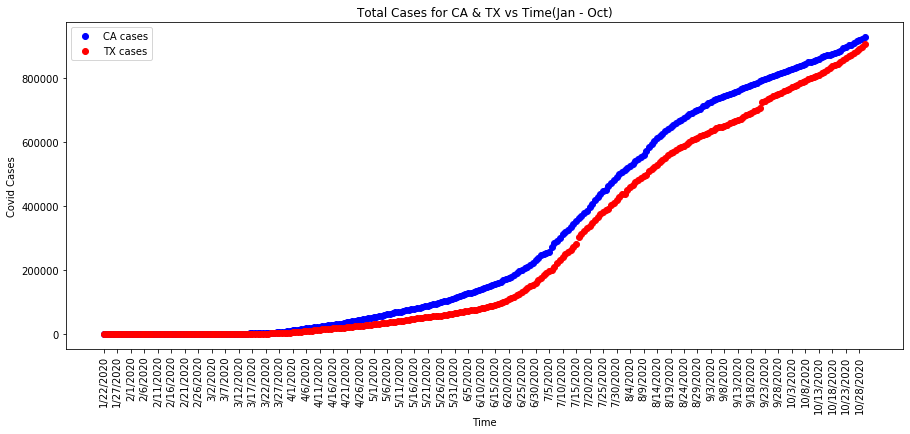

<Figure size 432x288 with 0 Axes>

In [47]:
#Line graph to plot the total covid cases vs Time 
fig, ax=plt.subplots(figsize=(15,6))
CA_cases=total_daily_cases["CA"]
x_axis=total_daily_cases.index
TX_cases=total_daily_cases["TX"]
CA, =plt.plot(x_axis, CA_cases,marker='o',color="blue",linewidth=0, label="CA cases")
TX, =plt.plot(x_axis, TX_cases,marker='o',color="red",linewidth=0,label="TX cases")
plt.legend(handles=[CA, TX],loc="best")
plt.xticks(rotation='vertical')
ax.set_xticks(ax.get_xticks()[::5])
plt.title("Total Cases for CA & TX vs Time(Jan - Oct)")
plt.xlabel("Time")
plt.ylabel("Covid Cases")
plt.show()
plt.savefig("../Images/Total Cases for CA & TX vs Time.png")

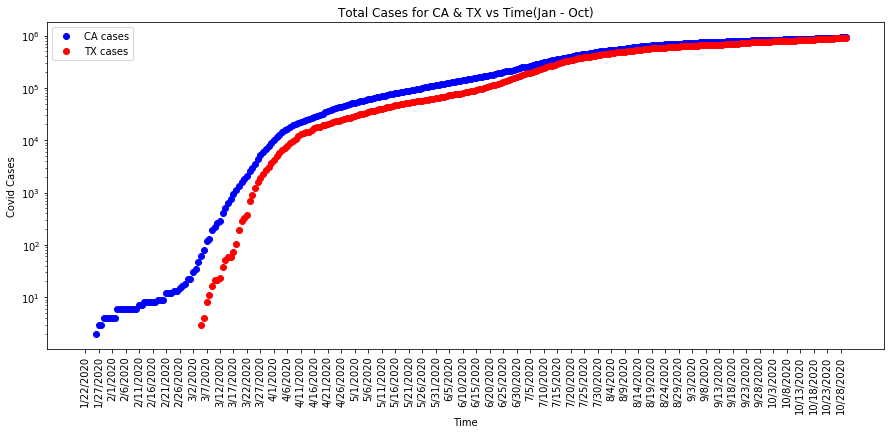

<Figure size 432x288 with 0 Axes>

In [48]:
#log scale to show the flatten of curve
fig, ax=plt.subplots(figsize=(15,6))
CA_cases=total_daily_cases["CA"]
x_axis=total_daily_cases.index
TX_cases=total_daily_cases["TX"]
CA, =plt.plot(x_axis, CA_cases,marker='o',color="blue",linewidth=0, label="CA cases")
TX, =plt.plot(x_axis, TX_cases,marker='o',color="red",linewidth=0,label="TX cases")
plt.legend(handles=[CA, TX],loc="best")
plt.xticks(rotation='vertical')
ax.set_xticks(ax.get_xticks()[::5])
ax.set_yscale('log')
plt.title("Total Cases for CA & TX vs Time(Jan - Oct)")
plt.xlabel("Time")
plt.ylabel("Covid Cases")
plt.show()
plt.savefig("../Images/Total Cases for CA & TX vs Time- log scale.png")

In [49]:
#New daily cases by state
new_daily_cases=total_daily_cases.diff()
new_daily_cases

State,CA,TX
1/22/2020,NaN,NaN
1/23/2020,0.0,0.0
1/24/2020,0.0,0.0
1/25/2020,0.0,0.0
1/26/2020,2.0,0.0
...,...,...
10/26/2020,5137.0,4727.0
10/27/2020,4520.0,7168.0
10/28/2020,4193.0,5804.0
10/29/2020,3909.0,7066.0


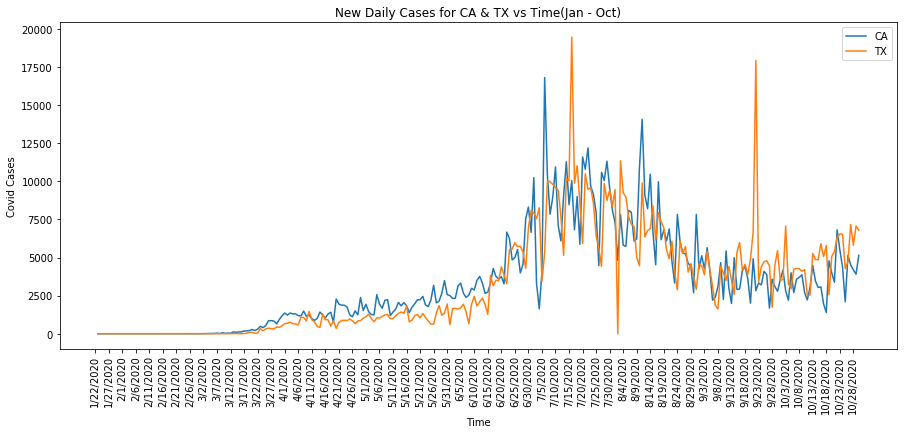

<Figure size 432x288 with 0 Axes>

In [50]:
#line graph2 for new daily cases
fig1,ax1=plt.subplots(figsize=(15,6))
ax1.plot(new_daily_cases)
plt.xticks(rotation='vertical')
ax1.set_xticks(ax1.get_xticks()[::5])
plt.legend(["CA", "TX"])
plt.title("New Daily Cases for CA & TX vs Time(Jan - Oct)")
plt.xlabel("Time")
plt.ylabel("Covid Cases")
plt.show()
plt.savefig("../Images/New Daily Cases for CA & TX vs Time.png")

In [51]:
covid_clean_CA_df = covid_clean_CA_TX_df.loc[covid_clean_CA_TX_df["State"]=="CA",:]
covid_clean_CA_df.head()

,State,countyFIPS,County Name,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,CA,6000,Grand Princess Cruise Ship,0,6,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
1,CA,6001,Alameda County,1671329,6,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
2,CA,6003,Alpine County,1129,6,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
3,CA,6005,Amador County,39752,6,0,0,0,0,0,...,276,287,291,291,291,299,301,302,308,311
4,CA,6007,Butte County,219186,6,0,0,0,0,0,...,3018,3030,3047,3047,3047,3073,3073,3113,3127,3144


In [52]:

covid_clean_TX_df = covid_clean_CA_TX_df.loc[covid_clean_CA_TX_df["State"]=="TX",:]
covid_clean_TX_df.head()

,State,countyFIPS,County Name,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
59,TX,48001,Anderson County,57735,48,0,0,0,0,0,...,2922,2934,2935,2941,2941,2946,2949,2961,2970,2970
60,TX,48003,Andrews County,18705,48,0,0,0,0,0,...,567,567,567,584,584,584,628,628,655,667
61,TX,48005,Angelina County,86715,48,0,0,0,0,0,...,2277,2277,2277,2277,2277,2277,2304,2304,2317,2317
62,TX,48007,Aransas County,23510,48,0,0,0,0,0,...,340,340,345,346,348,348,349,350,350,351
63,TX,48009,Archer County,8553,48,0,0,0,0,0,...,133,133,136,137,137,137,142,154,160,161


In [53]:
CA_county_landsize_df = pd.read_csv(CA_county_landsize, encoding="ISO-8859-1")
CA_county_landsize_df = CA_county_landsize_df.rename(columns={"ï»¿Land Area": "Land Area"})
CA_county_landsize_df.head()

,Land Area,County Name
0,20056.92,San Bernardino County
1,10180.87,Inyo County
2,8131.91,Kern County
3,7206.47,Riverside County
4,6277.88,Siskiyou County


In [54]:
TX_county_landsize_df = pd.read_csv(TX_county_landsize, encoding="ISO-8859-1")
TX_county_landsize_df = TX_county_landsize_df.rename(columns={"ï»¿Land Area": "Land Area"})
TX_county_landsize_df.head()

,Land Area,County Name
0,1062.6,Anderson County
1,1500.7,Andrews County
2,797.8,Angelina County
3,252.1,Aransas County
4,903.3,Archer County


In [55]:
#Merging the land size with covid clean data for TX
final_TX_pd = pd.merge(covid_clean_TX_df, TX_county_landsize_df, how="left", on=["County Name"])
final_TX_pd = final_TX_pd.dropna()
final_TX_pd["Population Density"]=""
final_TX_pd["Covid Per Capita"]= ""
final_TX_pd.head()

,State,countyFIPS,County Name,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020,Land Area,Population Density,Covid Per Capita
0,TX,48001,Anderson County,57735,48,0,0,0,0,0,...,2941,2941,2946,2949,2961,2970,2970,1062.6,,
1,TX,48003,Andrews County,18705,48,0,0,0,0,0,...,584,584,584,628,628,655,667,1500.7,,
2,TX,48005,Angelina County,86715,48,0,0,0,0,0,...,2277,2277,2277,2304,2304,2317,2317,797.8,,
3,TX,48007,Aransas County,23510,48,0,0,0,0,0,...,346,348,348,349,350,350,351,252.1,,
4,TX,48009,Archer County,8553,48,0,0,0,0,0,...,137,137,137,142,154,160,161,903.3,,


In [56]:
#Calculating the population density and covid per capita
final_TX_pd["Population Density"]= final_TX_pd['population']/final_TX_pd['Land Area']
final_TX_pd["Covid Per Capita"]= final_TX_pd['10/30/2020']/final_TX_pd['population']
final_TX_pd.sort_values("Population Density", ascending=False)
final_TX_pd.head()

,State,countyFIPS,County Name,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020,Land Area,Population Density,Covid Per Capita
0,TX,48001,Anderson County,57735,48,0,0,0,0,0,...,2941,2941,2946,2949,2961,2970,2970,1062.6,54.333710,0.051442
1,TX,48003,Andrews County,18705,48,0,0,0,0,0,...,584,584,584,628,628,655,667,1500.7,12.464183,0.035659
2,TX,48005,Angelina County,86715,48,0,0,0,0,0,...,2277,2277,2277,2304,2304,2317,2317,797.8,108.692655,0.026720
3,TX,48007,Aransas County,23510,48,0,0,0,0,0,...,346,348,348,349,350,350,351,252.1,93.256644,0.014930
4,TX,48009,Archer County,8553,48,0,0,0,0,0,...,137,137,137,142,154,160,161,903.3,9.468615,0.018824


In [57]:
#Merging the land size with covid clean data for CA
final_CA_pd = pd.merge(covid_clean_CA_df, CA_county_landsize_df, how="left", on=["County Name"])
final_CA_pd = final_CA_pd.dropna()
# Calculating populatin density
final_CA_pd["Population Density"]= ""
final_CA_pd["Population Density"]= final_CA_pd['population']/final_CA_pd['Land Area']
# Calculating Covid Per Capita
final_CA_pd["Covid Per Capita"]= ""
final_CA_pd["Covid Per Capita"]= final_CA_pd['10/30/2020']/final_CA_pd['population']
final_CA_pd.sort_values("Population Density", ascending=False)
final_CA_pd.head()

,State,countyFIPS,County Name,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020,Land Area,Population Density,Covid Per Capita
1,CA,6001,Alameda County,1671329,6,0,0,0,0,0,...,23215,23312,23391,23391,23576,23636,23775,739.02,2261.547725,0.014225
2,CA,6003,Alpine County,1129,6,0,0,0,0,0,...,3,3,3,3,3,3,3,738.33,1.529127,0.002657
3,CA,6005,Amador County,39752,6,0,0,0,0,0,...,291,291,299,301,302,308,311,594.58,66.857277,0.007824
4,CA,6007,Butte County,219186,6,0,0,0,0,0,...,3047,3047,3073,3073,3113,3127,3144,1636.46,133.939112,0.014344
5,CA,6009,Calaveras County,45905,6,0,0,0,0,0,...,342,342,342,342,347,347,354,1020.01,45.004461,0.007712


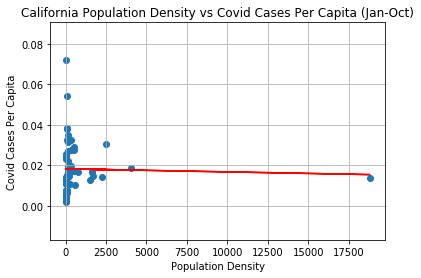

The rvalue is :-0.029944366890738257


<Figure size 432x288 with 0 Axes>

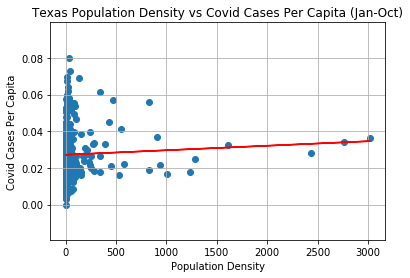

The rvalue is :0.05901251679703986


<Figure size 432x288 with 0 Axes>

In [58]:
#Plot Population Densoity vs Covid Cases per Captia for CA and TX

#CA 
x_values = final_CA_pd["Population Density"]
y_values = final_CA_pd["Covid Per Capita"]
plt.figure()
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.title("California Population Density vs Covid Cases Per Capita (Jan-Oct)")
plt.xlabel("Population Density")
plt.ylabel("Covid Cases Per Capita")
plt.grid(True)
plt.show()
plt.savefig("../Images/CAPop_Density_vs_Covid_Cases.png")
print(f"The rvalue is :{rvalue}")

#TX
x_values = final_TX_pd["Population Density"]
y_values = final_TX_pd["Covid Per Capita"]
plt.figure()
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.title("Texas Population Density vs Covid Cases Per Capita (Jan-Oct)")
plt.xlabel("Population Density")
plt.ylabel("Covid Cases Per Capita")
plt.grid(True)
plt.show()
plt.savefig("../Images/TXPop_Density_vs_Covid_Cases.png")
print(f"The rvalue is :{rvalue}")

In [59]:
#CA covid per capita bins
bins = [100, 5000, 25000, 50000, 250000, 500000, 750000, 1250000]
population_sizes = ["100-4999","5000-24999","25000-49999","50000-249999", "250000-499999", "500000-749999","750000-1250000"]

final_CA_pd["Population Bins"] = pd.cut(final_CA_pd["population"], bins, labels=population_sizes, include_lowest=True)
final_CA_bins_pd = final_CA_pd.dropna()
final_CA_bins_pd = final_CA_bins_pd[["Population Bins", "Covid Per Capita"]] 
final_CA_bins_pd = final_CA_bins_pd.groupby("Population Bins").sum()
final_CA_bins_pd = final_CA_bins_pd.rename(columns={"Covid Per Capita": "CA Covid Per Capita"})
final_CA_bins_pd

,CA Covid Per Capita
Population Bins,
100-4999,0.004654
5000-24999,0.068902
25000-49999,0.076726
50000-249999,0.335645
250000-499999,0.223152
500000-749999,0.032456
750000-1250000,0.160814


In [60]:
#CA population density bins
bins = [100, 5000, 25000, 50000, 250000, 500000, 750000, 1250000]
population_sizes = ["100-4999","5000-24999","25000-49999","50000-249999", "250000-499999", "500000-749999","750000-1250000"]

final_CA_pd["Population Bins"] = pd.cut(final_CA_pd["population"], bins, labels=population_sizes, include_lowest=True)
final_CA_bins_den_pd = final_CA_pd.dropna()
final_CA_bins_den_pd = final_CA_bins_den_pd[["Population Bins", "Population Density"]] 
final_CA_bins_den_pd = final_CA_bins_den_pd.groupby("Population Bins").sum()
final_CA_bins_den_pd = final_CA_bins_den_pd.rename(columns={"Population Density": "CA Population Density"})
final_CA_bins_den_pd

,CA Population Density
Population Bins,
100-4999,4.681632
5000-24999,50.594883
25000-49999,174.774280
50000-249999,1518.431810
250000-499999,2874.240164
500000-749999,368.376337
750000-1250000,23414.309330


In [61]:
#TX covid per capita bins
bins = [100, 5000, 25000, 50000, 250000, 500000, 750000, 1250000]
population_sizes = ["100-4999","5000-24999","25000-49999","50000-249999", "250000-499999", "500000-749999","750000-1250000"]

final_TX_pd["Population Bins"] = pd.cut(final_TX_pd["population"], bins, labels=population_sizes, include_lowest=True)
final_TX_bins_pd = final_TX_pd.dropna()
final_TX_bins_pd = final_TX_bins_pd[["Population Bins", "Covid Per Capita"]]
final_TX_bins_pd = final_TX_bins_pd.groupby("Population Bins").sum()
final_TX_bins_pd = final_TX_bins_pd.rename(columns={"Covid Per Capita": "TX Covid Per Capita"})
final_TX_bins_pd

,TX Covid Per Capita
Population Bins,
100-4999,1.071201
5000-24999,2.936157
25000-49999,0.935296
50000-249999,1.309095
250000-499999,0.380029
500000-749999,0.038107
750000-1250000,0.153234


In [62]:
#TX population density bins
bins = [100, 5000, 25000, 50000, 250000, 500000, 750000, 1250000]
population_sizes = ["100-4999","5000-24999","25000-49999","50000-249999", "250000-499999", "500000-749999","750000-1250000"]

final_TX_pd["Population Bins"] = pd.cut(final_CA_pd["population"], bins, labels=population_sizes, include_lowest=True)
final_TX_bins_den_pd = final_TX_pd.dropna()
final_TX_bins_den_pd = final_TX_bins_den_pd[["Population Bins", "Population Density"]] 
final_TX_bins_den_pd = final_TX_bins_den_pd.groupby("Population Bins").sum()
final_TX_bins_den_pd = final_TX_bins_den_pd.rename(columns={"Population Density": "TX Population Density"})
final_TX_bins_den_pd

,TX Population Density
Population Bins,
100-4999,123.232002
5000-24999,1748.243939
25000-49999,215.974079
50000-249999,1287.243175
250000-499999,1564.468728
500000-749999,1.552298
750000-1250000,3201.854502


In [63]:
#Final population density bins for TX & CA

final_CA_TX_bins_den = pd.concat([final_TX_bins_den_pd,final_CA_bins_den_pd], axis=1)
final_CA_TX_bins_den

,TX Population Density,CA Population Density
Population Bins,,
100-4999,123.232002,4.681632
5000-24999,1748.243939,50.594883
25000-49999,215.974079,174.774280
50000-249999,1287.243175,1518.431810
250000-499999,1564.468728,2874.240164
500000-749999,1.552298,368.376337
750000-1250000,3201.854502,23414.309330


In [64]:
#Final covid per capita bins for TX & CA
final_CA_TX_bins = pd.concat([final_TX_bins_pd,final_CA_bins_pd], axis=1)
final_CA_TX_bins

,TX Covid Per Capita,CA Covid Per Capita
Population Bins,,
100-4999,1.071201,0.004654
5000-24999,2.936157,0.068902
25000-49999,0.935296,0.076726
50000-249999,1.309095,0.335645
250000-499999,0.380029,0.223152
500000-749999,0.038107,0.032456
750000-1250000,0.153234,0.160814


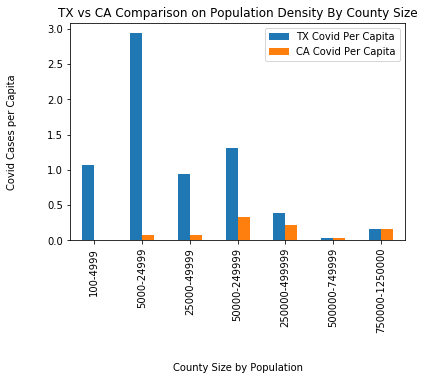

In [65]:
#Bar graph

final_CA_TX_bins = final_CA_TX_bins.plot(kind="bar")
final_CA_TX_bins.set_ylabel("Covid Cases per Capita", labelpad=30)
final_CA_TX_bins.set_xlabel("County Size by Population", labelpad=30)
final_CA_TX_bins.set_title("TX vs CA Comparison on Population Density By County Size")
plt.savefig("../Images/TX_CA_Covid_per_Capita.png")

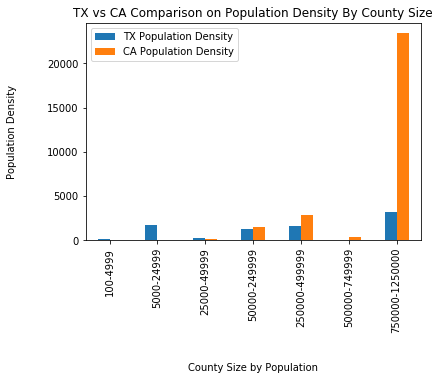

In [66]:

final_CA_TX_bins_den = final_CA_TX_bins_den.plot(kind="bar")
final_CA_TX_bins_den.set_ylabel("Population Density", labelpad=30)
final_CA_TX_bins_den.set_xlabel("County Size by Population", labelpad=30)
final_CA_TX_bins_den.set_title("TX vs CA Comparison on Population Density By County Size")
plt.savefig("../Images/TX_CA_Pop_Density_png")

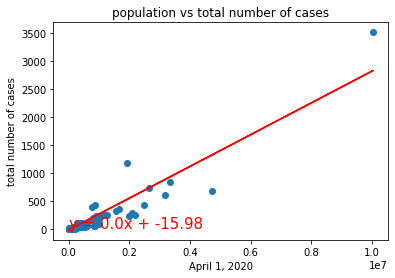

The correlation is 0.93.


<Figure size 432x288 with 0 Axes>

In [67]:
#Linear Regression
x_values = covid_clean_CA_TX_df['population']
y_values = covid_clean_CA_TX_df['4/1/2020']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values, y_values) 
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.title("population vs total number of cases")
plt.xlabel('April 1, 2020')
plt.ylabel('total number of cases')
plt.show()
# print(rvalue)
correlation = st.pearsonr(covid_clean_CA_TX_df["population"], covid_clean_CA_TX_df["4/1/2020"])
print(f"The correlation is {round(correlation[0],2)}.")

plt.savefig("../Images/LinearRegressionApril.png")

In [68]:
correlation = st.pearsonr(covid_clean_CA_TX_df["population"], covid_clean_CA_TX_df["4/1/2020"])
print(f"The correlation is {round(correlation[0],2)}.")

The correlation is 0.93.


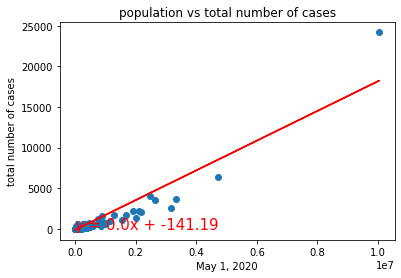

The correlation is 0.94.


<Figure size 432x288 with 0 Axes>

In [69]:

x_values = covid_clean_CA_TX_df['population']
y_values = covid_clean_CA_TX_df['5/1/2020']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values, y_values) 
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10,10),fontsize=15,color="red")
plt.title("population vs total number of cases")
plt.xlabel('May 1, 2020')
plt.ylabel('total number of cases')
plt.show()
# print(rvalue)
correlation = st.pearsonr(covid_clean_CA_TX_df["population"], covid_clean_CA_TX_df["5/1/2020"])
print(f"The correlation is {round(correlation[0],2)}.")
plt.savefig("../Images/LinearRegressionMay.png")

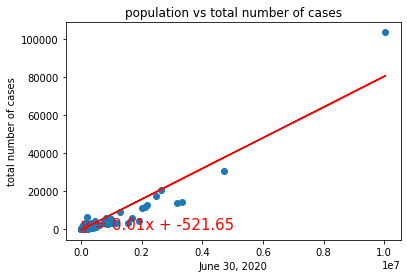

The correlation is 0.94.


<Figure size 432x288 with 0 Axes>

In [70]:

x_values = covid_clean_CA_TX_df['population']
y_values = covid_clean_CA_TX_df['6/30/2020']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values, y_values) 
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.title("population vs total number of cases")
plt.xlabel('June 30, 2020')
plt.ylabel('total number of cases')
plt.show()
# print(rvalue)
correlation = st.pearsonr(covid_clean_CA_TX_df["population"], covid_clean_CA_TX_df["6/30/2020"])
print(f"The correlation is {round(correlation[0],2)}.")
plt.savefig("../Images/LinearRegressionJune.png")

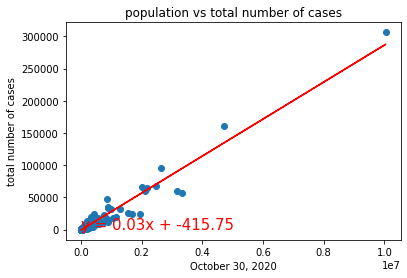

The correlation is 0.97.


<Figure size 432x288 with 0 Axes>

In [71]:
x_values = covid_clean_CA_TX_df['population']
y_values = covid_clean_CA_TX_df['10/30/2020']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values, y_values) 
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.title("population vs total number of cases")
plt.xlabel('October 30, 2020')
plt.ylabel('total number of cases')
plt.show()
# print(rvalue)
correlation = st.pearsonr(covid_clean_CA_TX_df["population"], covid_clean_CA_TX_df["10/30/2020"])
print(f"The correlation is {round(correlation[0],2)}.")
plt.savefig("../Images/LinearRegressionOctober.png")

In [76]:
#HEAT MAPS

#Extracting head information
CA_TX_population = covid_clean_CA_TX[covid_clean_CA_TX.columns[0:4]]
CA_TX_population

,State,countyFIPS,County Name,population
1,CA,6000,Grand Princess Cruise Ship,0
2,CA,6001,Alameda County,1671329
3,CA,6003,Alpine County,1129
4,CA,6005,Amador County,39752
5,CA,6007,Butte County,219186
...,...,...,...,...
310,TX,48499,Wood County,45539
311,TX,48501,Yoakum County,8713
312,TX,48503,Young County,18010
313,TX,48505,Zapata County,14179


In [77]:
#Dropping columns for future biweekly count
daily_cases= covid_clean_CA_TX.drop(columns=["State", 'countyFIPS','County Name','stateFIPS','population'])
daily_cases

,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
1,0,0,0,0,0,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
2,0,0,0,0,0,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
3,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
4,0,0,0,0,0,0,0,0,0,0,...,276,287,291,291,291,299,301,302,308,311
5,0,0,0,0,0,0,0,0,0,0,...,3018,3030,3047,3047,3047,3073,3073,3113,3127,3144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,0,0,0,0,0,0,0,0,0,0,...,621,623,626,626,626,633,636,639,655,655
311,0,0,0,0,0,0,0,0,0,0,...,289,289,289,289,289,289,289,300,304,319
312,0,0,0,0,0,0,0,0,0,0,...,497,507,521,535,535,535,559,578,591,605
313,0,0,0,0,0,0,0,0,0,0,...,342,342,343,345,346,346,352,352,352,357


In [78]:
#Extracting cases by the end of every two weeks for biweekly count
biweekly_cases_count = daily_cases[daily_cases.columns[::14]]
biweekly_cases_count

,1/22/2020,2/5/2020,2/19/2020,3/4/2020,3/18/2020,4/1/2020,4/15/2020,4/29/2020,5/13/2020,5/27/2020,...,6/24/2020,7/8/2020,7/22/2020,8/5/2020,8/19/2020,9/2/2020,9/16/2020,9/30/2020,10/14/2020,10/28/2020
1,0,0,0,0,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
2,0,0,0,1,31,359,962,1568,2178,3049,...,5275,7245,9643,12136,15836,18695,20097,21383,22325,23576
3,0,0,0,0,0,1,2,2,2,2,...,2,2,2,2,2,2,2,2,3,3
4,0,0,0,0,1,3,7,8,9,10,...,19,35,65,156,218,237,247,257,271,302
5,0,0,0,0,0,9,16,16,20,40,...,127,295,683,1029,1494,2208,2638,2804,2948,3113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,0,0,0,0,0,1,6,7,15,25,...,77,115,196,313,373,408,472,526,579,639
311,0,0,0,0,0,0,0,1,2,3,...,15,40,55,90,129,155,198,224,278,300
312,0,0,0,0,0,3,4,4,4,4,...,22,38,81,151,203,226,258,332,404,578
313,0,0,0,0,0,0,4,7,7,8,...,40,63,115,165,231,281,321,333,342,352


In [79]:
#Biweekly count 
biweekly_cases_count_for_merge = biweekly_cases_count.diff(axis=1, periods=1)
biweekly_cases_count_for_merge
#dropping first date in the dataframe for future merging two dataframes
biweekly_cases_count_for_merge = biweekly_cases_count_for_merge.drop(columns=["1/22/2020"])
biweekly_cases_count_for_merge

,2/5/2020,2/19/2020,3/4/2020,3/18/2020,4/1/2020,4/15/2020,4/29/2020,5/13/2020,5/27/2020,6/10/2020,6/24/2020,7/8/2020,7/22/2020,8/5/2020,8/19/2020,9/2/2020,9/16/2020,9/30/2020,10/14/2020,10/28/2020
1,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,30.0,328.0,603.0,606.0,610.0,871.0,984.0,1242.0,1970.0,2398.0,2493.0,3700.0,2859.0,1402.0,1286.0,942.0,1251.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,2.0,4.0,1.0,1.0,1.0,0.0,9.0,16.0,30.0,91.0,62.0,19.0,10.0,10.0,14.0,31.0
5,0.0,0.0,0.0,0.0,9.0,7.0,0.0,4.0,20.0,33.0,54.0,168.0,388.0,346.0,465.0,714.0,430.0,166.0,144.0,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,0.0,0.0,0.0,0.0,1.0,5.0,1.0,8.0,10.0,26.0,26.0,38.0,81.0,117.0,60.0,35.0,64.0,54.0,53.0,60.0
311,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,7.0,25.0,15.0,35.0,39.0,26.0,43.0,26.0,54.0,22.0
312,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,7.0,11.0,16.0,43.0,70.0,52.0,23.0,32.0,74.0,72.0,174.0
313,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,1.0,4.0,28.0,23.0,52.0,50.0,66.0,50.0,40.0,12.0,9.0,10.0


In [80]:
#Merging dataframes
biweekly_cases_CA_TX = CA_TX_population.join(biweekly_cases_count_for_merge, how="outer")
biweekly_cases_CA_TX

,State,countyFIPS,County Name,population,2/5/2020,2/19/2020,3/4/2020,3/18/2020,4/1/2020,4/15/2020,...,6/24/2020,7/8/2020,7/22/2020,8/5/2020,8/19/2020,9/2/2020,9/16/2020,9/30/2020,10/14/2020,10/28/2020
1,CA,6000,Grand Princess Cruise Ship,0,0.0,0.0,0.0,21.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CA,6001,Alameda County,1671329,0.0,0.0,1.0,30.0,328.0,603.0,...,1242.0,1970.0,2398.0,2493.0,3700.0,2859.0,1402.0,1286.0,942.0,1251.0
3,CA,6003,Alpine County,1129,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CA,6005,Amador County,39752,0.0,0.0,0.0,1.0,2.0,4.0,...,9.0,16.0,30.0,91.0,62.0,19.0,10.0,10.0,14.0,31.0
5,CA,6007,Butte County,219186,0.0,0.0,0.0,0.0,9.0,7.0,...,54.0,168.0,388.0,346.0,465.0,714.0,430.0,166.0,144.0,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,TX,48499,Wood County,45539,0.0,0.0,0.0,0.0,1.0,5.0,...,26.0,38.0,81.0,117.0,60.0,35.0,64.0,54.0,53.0,60.0
311,TX,48501,Yoakum County,8713,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,25.0,15.0,35.0,39.0,26.0,43.0,26.0,54.0,22.0
312,TX,48503,Young County,18010,0.0,0.0,0.0,0.0,3.0,1.0,...,11.0,16.0,43.0,70.0,52.0,23.0,32.0,74.0,72.0,174.0
313,TX,48505,Zapata County,14179,0.0,0.0,0.0,0.0,0.0,4.0,...,28.0,23.0,52.0,50.0,66.0,50.0,40.0,12.0,9.0,10.0


In [81]:
#Saving the final data
biweekly_cases_CA_TX.to_csv("../Resources/biweekly_cases_CA_TX.csv", index=False, header=True)


In [2]:
from Api_keys import api_keys
# Accessing maps with unique API key
gmaps.configure(api_key=api_keys)

In [4]:
#Reading the file
biweekly_cases_CA_TX = pd.read_csv("../Resources/biweekly_cases_CA_TX.csv")
biweekly_cases_CA_TX

,State,countyFIPS,County Name,population,2/5/2020,2/19/2020,3/4/2020,3/18/2020,4/1/2020,4/15/2020,...,6/24/2020,7/8/2020,7/22/2020,8/5/2020,8/19/2020,9/2/2020,9/16/2020,9/30/2020,10/14/2020,10/28/2020
0,CA,6000,Grand Princess Cruise Ship,0,0.0,0.0,0.0,21.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CA,6001,Alameda County,1671329,0.0,0.0,1.0,30.0,328.0,603.0,...,1242.0,1970.0,2398.0,2493.0,3700.0,2859.0,1402.0,1286.0,942.0,1251.0
2,CA,6003,Alpine County,1129,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CA,6005,Amador County,39752,0.0,0.0,0.0,1.0,2.0,4.0,...,9.0,16.0,30.0,91.0,62.0,19.0,10.0,10.0,14.0,31.0
4,CA,6007,Butte County,219186,0.0,0.0,0.0,0.0,9.0,7.0,...,54.0,168.0,388.0,346.0,465.0,714.0,430.0,166.0,144.0,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,TX,48499,Wood County,45539,0.0,0.0,0.0,0.0,1.0,5.0,...,26.0,38.0,81.0,117.0,60.0,35.0,64.0,54.0,53.0,60.0
309,TX,48501,Yoakum County,8713,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,25.0,15.0,35.0,39.0,26.0,43.0,26.0,54.0,22.0
310,TX,48503,Young County,18010,0.0,0.0,0.0,0.0,3.0,1.0,...,11.0,16.0,43.0,70.0,52.0,23.0,32.0,74.0,72.0,174.0
311,TX,48505,Zapata County,14179,0.0,0.0,0.0,0.0,0.0,4.0,...,28.0,23.0,52.0,50.0,66.0,50.0,40.0,12.0,9.0,10.0


In [5]:
#Adding coordinations for future heat maps
biweekly_cases_CA_TX.insert(4, "Lat", "")
biweekly_cases_CA_TX.insert(5, "Lng", "")
biweekly_cases_CA_TX

,State,countyFIPS,County Name,population,Lat,Lng,2/5/2020,2/19/2020,3/4/2020,3/18/2020,...,6/24/2020,7/8/2020,7/22/2020,8/5/2020,8/19/2020,9/2/2020,9/16/2020,9/30/2020,10/14/2020,10/28/2020
0,CA,6000,Grand Princess Cruise Ship,0,,,0.0,0.0,0.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CA,6001,Alameda County,1671329,,,0.0,0.0,1.0,30.0,...,1242.0,1970.0,2398.0,2493.0,3700.0,2859.0,1402.0,1286.0,942.0,1251.0
2,CA,6003,Alpine County,1129,,,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CA,6005,Amador County,39752,,,0.0,0.0,0.0,1.0,...,9.0,16.0,30.0,91.0,62.0,19.0,10.0,10.0,14.0,31.0
4,CA,6007,Butte County,219186,,,0.0,0.0,0.0,0.0,...,54.0,168.0,388.0,346.0,465.0,714.0,430.0,166.0,144.0,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,TX,48499,Wood County,45539,,,0.0,0.0,0.0,0.0,...,26.0,38.0,81.0,117.0,60.0,35.0,64.0,54.0,53.0,60.0
309,TX,48501,Yoakum County,8713,,,0.0,0.0,0.0,0.0,...,7.0,25.0,15.0,35.0,39.0,26.0,43.0,26.0,54.0,22.0
310,TX,48503,Young County,18010,,,0.0,0.0,0.0,0.0,...,11.0,16.0,43.0,70.0,52.0,23.0,32.0,74.0,72.0,174.0
311,TX,48505,Zapata County,14179,,,0.0,0.0,0.0,0.0,...,28.0,23.0,52.0,50.0,66.0,50.0,40.0,12.0,9.0,10.0


In [6]:
# Creating a params dict that will be updated with new city each iteration
params = {"key": api_keys}
Lat = []
Lng = []
# Looping through the dataframe and run a lat/long search for each county
for index, row in biweekly_cases_CA_TX.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"

    county = row['County Name']
    state = row['State']

    params['address'] = f"{county},{state}"

    counties_lat_lng = requests.get(base_url, params=params)
    
    counties_lat_lng = counties_lat_lng.json()
    try:
        biweekly_cases_CA_TX.loc[index, "Lat"] = counties_lat_lng["results"][0]["geometry"]["location"]["lat"]
        biweekly_cases_CA_TX.loc[index, "Lng"] = counties_lat_lng["results"][0]["geometry"]["location"]["lng"]
    except (KeyError, IndexError):
        print(f"For county {county} field/result are missing ... skipping.")
#Dropping rows with cities information on which is missing
        biweekly_cases_CA_TX.drop(index=index, axis=0, inplace=True)

biweekly_cases_CA_TX

,State,countyFIPS,County Name,population,Lat,Lng,2/5/2020,2/19/2020,3/4/2020,3/18/2020,...,6/24/2020,7/8/2020,7/22/2020,8/5/2020,8/19/2020,9/2/2020,9/16/2020,9/30/2020,10/14/2020,10/28/2020
0,CA,6000,Grand Princess Cruise Ship,0,34.4189,-118.56,0.0,0.0,0.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CA,6001,Alameda County,1671329,37.6017,-121.72,0.0,0.0,1.0,30.0,...,1242.0,1970.0,2398.0,2493.0,3700.0,2859.0,1402.0,1286.0,942.0,1251.0
2,CA,6003,Alpine County,1129,38.5941,-119.882,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CA,6005,Amador County,39752,38.3489,-120.774,0.0,0.0,0.0,1.0,...,9.0,16.0,30.0,91.0,62.0,19.0,10.0,10.0,14.0,31.0
4,CA,6007,Butte County,219186,39.6254,-121.537,0.0,0.0,0.0,0.0,...,54.0,168.0,388.0,346.0,465.0,714.0,430.0,166.0,144.0,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,TX,48499,Wood County,45539,32.8296,-95.3521,0.0,0.0,0.0,0.0,...,26.0,38.0,81.0,117.0,60.0,35.0,64.0,54.0,53.0,60.0
309,TX,48501,Yoakum County,8713,33.2115,-102.898,0.0,0.0,0.0,0.0,...,7.0,25.0,15.0,35.0,39.0,26.0,43.0,26.0,54.0,22.0
310,TX,48503,Young County,18010,33.22,-98.7481,0.0,0.0,0.0,0.0,...,11.0,16.0,43.0,70.0,52.0,23.0,32.0,74.0,72.0,174.0
311,TX,48505,Zapata County,14179,26.9731,-99.1013,0.0,0.0,0.0,0.0,...,28.0,23.0,52.0,50.0,66.0,50.0,40.0,12.0,9.0,10.0


In [7]:
biweekly_cases_CA_TX.columns

Index(['State', 'countyFIPS', 'County Name', 'population', 'Lat', 'Lng',
       '2/5/2020', '2/19/2020', '3/4/2020', '3/18/2020', '4/1/2020',
       '4/15/2020', '4/29/2020', '5/13/2020', '5/27/2020', '6/10/2020',
       '6/24/2020', '7/8/2020', '7/22/2020', '8/5/2020', '8/19/2020',
       '9/2/2020', '9/16/2020', '9/30/2020', '10/14/2020', '10/28/2020'],
      dtype='object')

In [8]:

biweekly_cases_CA_TX = biweekly_cases_CA_TX.dropna()

In [9]:
#Extracting data for March 18 (before lockdown)
march_18_1 = biweekly_cases_CA_TX[["State", "County Name", "Lat", "Lng", "3/18/2020"]]
march_18_1

,State,County Name,Lat,Lng,3/18/2020
0,CA,Grand Princess Cruise Ship,34.4189,-118.56,21.0
1,CA,Alameda County,37.6017,-121.72,30.0
2,CA,Alpine County,38.5941,-119.882,0.0
3,CA,Amador County,38.3489,-120.774,1.0
4,CA,Butte County,39.6254,-121.537,0.0
...,...,...,...,...,...
308,TX,Wood County,32.8296,-95.3521,0.0
309,TX,Yoakum County,33.2115,-102.898,0.0
310,TX,Young County,33.22,-98.7481,0.0
311,TX,Zapata County,26.9731,-99.1013,0.0


In [10]:

#Creating a heated map March 18
locations = march_18_1[["Lat", "Lng"]]
infections = march_18_1["3/18/2020"]
fig = gmaps.figure()

infection_layer = gmaps.heatmap_layer(locations, weights=infections, 
                                 dissipating=False, max_intensity=march_18_1["3/18/2020"].max(),
                                 point_radius=1)
fig.add_layer(infection_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [11]:
#Extracting data for March 18 (before ending lockdown for texas and lifting restrictions for California)
april_29_1 = biweekly_cases_CA_TX[["State", "County Name", "Lat", "Lng", "4/29/2020"]]
april_29_1

,State,County Name,Lat,Lng,4/29/2020
0,CA,Grand Princess Cruise Ship,34.4189,-118.56,0.0
1,CA,Alameda County,37.6017,-121.72,606.0
2,CA,Alpine County,38.5941,-119.882,0.0
3,CA,Amador County,38.3489,-120.774,1.0
4,CA,Butte County,39.6254,-121.537,0.0
...,...,...,...,...,...
308,TX,Wood County,32.8296,-95.3521,1.0
309,TX,Yoakum County,33.2115,-102.898,1.0
310,TX,Young County,33.22,-98.7481,0.0
311,TX,Zapata County,26.9731,-99.1013,3.0


In [12]:
#Creating a heated map April 29
locations = april_29_1[["Lat", "Lng"]]
infections = april_29_1["4/29/2020"]
fig = gmaps.figure()

infection_layer = gmaps.heatmap_layer(locations, weights=infections, 
                                 dissipating=False, max_intensity=april_29_1["4/29/2020"].max(),
                                 point_radius=1)
fig.add_layer(infection_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [13]:
#May 27
may_27 = biweekly_cases_CA_TX[["State", "County Name", "Lat", "Lng", "5/27/2020"]]
may_27

,State,County Name,Lat,Lng,5/27/2020
0,CA,Grand Princess Cruise Ship,34.4189,-118.56,0.0
1,CA,Alameda County,37.6017,-121.72,871.0
2,CA,Alpine County,38.5941,-119.882,0.0
3,CA,Amador County,38.3489,-120.774,1.0
4,CA,Butte County,39.6254,-121.537,20.0
...,...,...,...,...,...
308,TX,Wood County,32.8296,-95.3521,10.0
309,TX,Yoakum County,33.2115,-102.898,1.0
310,TX,Young County,33.22,-98.7481,0.0
311,TX,Zapata County,26.9731,-99.1013,1.0


In [14]:
locations = may_27[["Lat", "Lng"]]
infections = may_27["5/27/2020"]
fig = gmaps.figure()

infection_layer = gmaps.heatmap_layer(locations, weights=infections, 
                                 dissipating=False, max_intensity=may_27["5/27/2020"].max(),
                                 point_radius=1)
fig.add_layer(infection_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [15]:
#June 24
june_24 = biweekly_cases_CA_TX[["State", "County Name", "Lat", "Lng", "6/24/2020"]]
june_24

,State,County Name,Lat,Lng,6/24/2020
0,CA,Grand Princess Cruise Ship,34.4189,-118.56,0.0
1,CA,Alameda County,37.6017,-121.72,1242.0
2,CA,Alpine County,38.5941,-119.882,0.0
3,CA,Amador County,38.3489,-120.774,9.0
4,CA,Butte County,39.6254,-121.537,54.0
...,...,...,...,...,...
308,TX,Wood County,32.8296,-95.3521,26.0
309,TX,Yoakum County,33.2115,-102.898,7.0
310,TX,Young County,33.22,-98.7481,11.0
311,TX,Zapata County,26.9731,-99.1013,28.0


In [16]:
locations = june_24[["Lat", "Lng"]]
infections = june_24["6/24/2020"]
fig = gmaps.figure()

infection_layer = gmaps.heatmap_layer(locations, weights=infections, 
                                 dissipating=False, max_intensity=june_24["6/24/2020"].max(),
                                 point_radius=1)
fig.add_layer(infection_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [17]:
#Latest data (results, October 28)
october_28 = biweekly_cases_CA_TX[["State", "County Name", "Lat", "Lng", "10/28/2020"]]
october_28

,State,County Name,Lat,Lng,10/28/2020
0,CA,Grand Princess Cruise Ship,34.4189,-118.56,0.0
1,CA,Alameda County,37.6017,-121.72,1251.0
2,CA,Alpine County,38.5941,-119.882,0.0
3,CA,Amador County,38.3489,-120.774,31.0
4,CA,Butte County,39.6254,-121.537,165.0
...,...,...,...,...,...
308,TX,Wood County,32.8296,-95.3521,60.0
309,TX,Yoakum County,33.2115,-102.898,22.0
310,TX,Young County,33.22,-98.7481,174.0
311,TX,Zapata County,26.9731,-99.1013,10.0


In [18]:
locations = october_28[["Lat", "Lng"]]
infections = october_28["10/28/2020"]
fig = gmaps.figure()

infection_layer = gmaps.heatmap_layer(locations, weights=infections, 
                                 dissipating=False, max_intensity=october_28["10/28/2020"].max(),
                                 point_radius=1)
fig.add_layer(infection_layer)
fig

Figure(layout=FigureLayout(height='420px'))